### Identify cause of convection in historical experiment when compared with present day

In [1]:
import xarray as xr
import numpy as np
import gsw
import cmocean
import matplotlib.pyplot as plt
import pandas as pd
import glob
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.constants import weddell_convect, ross_convect
# from nemo_python_git.timeseries import calc_hovmoeller_region

In [2]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
ens1011_dir = f'{base_dir}output/CESM2-present-day6/'
pre1011_dir = f'{base_dir}output/CESM2-present-day5/'
piC_dir     = f'{base_dir}output/CESM2-piControl_test1/' 
era5_dir    = f'{base_dir}output/ERA5_test6/'

In [7]:
def calc_hovmoeller_region(var, region, file_type='grid_T', region_name='Weddell',
                           run_folder='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/reference-4.2.2/',
                           nemo_mesh='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc'):
    # NEMO meshmask
    nemo_mesh_ds     = xr.open_dataset(f'{nemo_mesh}').isel(time_counter=0, x=region['x'], y=region['y']).rename({'nav_lev':'deptht'})
    
    # Load gridT files into dataset:
    files = glob.glob(f'{run_folder}eANT025*{file_type}*') 
    print('loading files')
    if file_type=='grid_T' or file_type=='SBC':
        kwags={'preprocess':lambda ds: ds[var + ['area_grid_T', 'time_counter']], 'chunks':'auto'}
        nemo_ds      = xr.open_mfdataset(files, **kwags).rename({'x_grid_T':'x', 'y_grid_T':'y', 'area_grid_T':'area'})
        if file_type=='SBC': 
            nemo_mesh_ds = nemo_mesh_ds.isel(deptht=0)
    elif file_type=='icemod' or file_type=='grid_W':
        kwags={'preprocess':lambda ds: ds[var + ['area', 'time_counter']], 'chunks':'auto'}
        nemo_ds      = xr.open_mfdataset(files, **kwags)
        if file_type=='icemod':
            nemo_mesh_ds = nemo_mesh_ds.isel(deptht=0)

    nemo_ds    = nemo_ds.isel(x=region['x'], y=region['y']) 
    area_ocean = xr.where(nemo_mesh_ds.tmask==0, np.nan, nemo_ds['area'])

    print('saving file')
    var_ds = xr.Dataset()
    for varname in var:
        print(varname)
        var_ocean  = xr.where(nemo_mesh_ds.tmask==0, np.nan, nemo_ds[varname])
        region_var = (var_ocean*area_ocean).sum(dim=['x','y'])/(area_ocean.sum(dim=['x','y']))
        var_ds     = var_ds.assign({f'{region_name}_{varname}':region_var})
        
    var_ds.to_netcdf(f'{run_folder}{region_name}_{file_type}_timeseries.nc')
    return var_ds

## Sea ice formation?

Look at monthly variable timeseries alongside the convection time series

In [5]:
icemod_files = glob.glob(f'{era5_dir}files/*icemod*')[0:2]
SBC_files    = glob.glob(f'{era5_dir}files/*SBC*')

In [6]:
ds_ice = xr.open_mfdataset(icemod_files, preprocess=lambda ds: ds[['sithic', 'area']], chunks='auto')

# ds_sbc = xr.open_mfdataset(SBC_files, decode_cf=False, parallel=True)

In [8]:
ice_vars = ['sithic', 'sisali', 'siapnd', 'sitemp', 'sidive', 'sishea', 'qt_oce_ai', 'qt_atm_oi', \
            'qtr_ice_bot', 'qt_ice', 'qemp_ice', 'sfxice']

# run_dirs = [f'{base_dir}output/CESM2-present-day6/files/', f'{base_dir}output/CESM2-present-day5/files_spinup/', 
#             f'{base_dir}output/CESM2-present-day5/files/', f'{base_dir}output/CESM2-piControl_test1/files/',
#             f'{base_dir}output/ERA5_test6/files/']
run_dirs = [f'{base_dir}output/CESM2-present-day6/files/']

In [9]:
for r, run_dir in enumerate(run_dirs):
    print(run_dir)
    var_weddell = calc_hovmoeller_region(ice_vars, ross_convect, region_name='Ross', run_folder=run_dir, file_type='icemod')

/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/CESM2-present-day5/files_spinup/
loading files
saving file
sithic
sisali
siapnd
sitemp
sidive
sishea
qt_oce_ai
qt_atm_oi
qtr_ice_bot
qt_ice
qemp_ice
sfxice


/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/CESM2-present-day6/
plotting
/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/CESM2-present-day5/
plotting
/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/CESM2-piControl_test1/
plotting


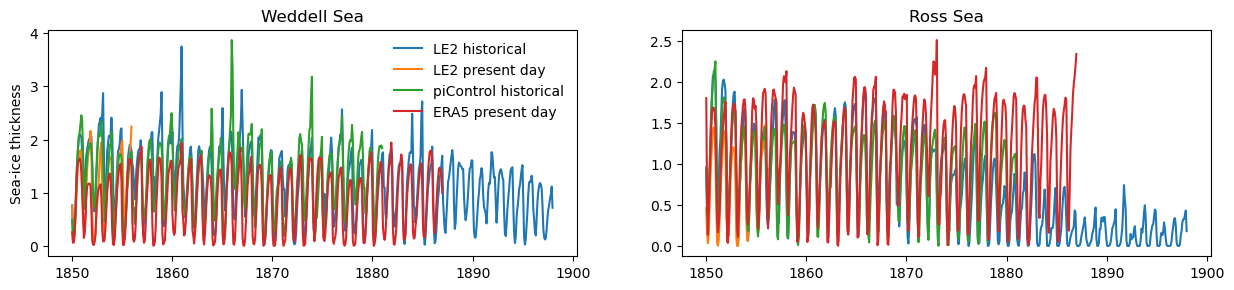

In [8]:
for var in ice_vars:
    print(var)
    
    fig, ax = plt.subplots(1,1, figsize=(10,3), dpi=100)
    ax.set_title('Weddell Sea')
    ax.set_ylabel(ds_ice[var].long_name)
    
    for r, run_dir in enumerate(run_dirs):
        print(run_dir)
        var_weddell = calc_hovmoeller_region(var, weddell_convect, run_folder=run_dir, file_type='icemod')
        # var_ross    = calc_hovmoeller_region(var, ross_convect   , run_folder=run_dir, file_type='icemod')

        # ds = xr.Dataset({f'Weddell_{var}':var_weddell, f'Ross_{var}':var_ross})
        
        # ds.to_netcdf(f'{run_dir}weddell_ross_icemod_timeseries.nc')

        print('plotting')
        if var_weddell.time_counter.dt.year[0]==1979:
            ax.plot(var_weddell.time_counter - pd.Timedelta(days=365*129+31), var_weddell, label=dir_name[r])
        elif spin_up2:
            ax.plot(var_weddell.time_counter - pd.Timedelta(days=365*100), var_weddell, label=dir_name[r])
            # ax[1].plot(var_ross.time_counter - pd.Timedelta(days=365*129+31)   , var_ross   , label=dir_name[r])
        else:
            ax.plot(var_weddell.time_counter, var_weddell, label=dir_name[r])
            # ax[1].plot(var_ross.time_counter   , var_ross, label=dir_name[r])
    
    ax.legend(frameon=False)

    fig.savefig('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/weddell_timeseries_{var}.jpg')

- write into timeseries code
- figure out why calculating the timeseries is so slow! The files are large, but still... same issue as when calculating bottom water timeseries etc.
- consider using xr open_mfdataset with multiple threads and write out to zarr

```
# I'm not sure if you have conflicting variable names - you'll need to
# tailor this line to your data setup. It may be that you want to just
# concatenate along years and then use `xr.merge` to combine the
# variables, or just handle one variable at a time
ds = xr.open_mfdataset(
    filepaths,
    combine='nested',
    concat_dim=['variable', 'year'],
    parallel=True,
)

# this will only schedule the operation - no work is done until the next line
ds_nodes = ds.sel(lat=node_indexer.lat, lon=node_indexer.lon)

# this triggers the operation using a dask LocalCluster, leveraging
# multiple threads on your machine (or a distributed Client if you have
# one set up)
ds_nodes.to_netcdf('all_the_data.zarr')

xr.to_zarr(append=True)

# alternatively, you could still dump to pandas:
df = ds_nodes.to_dataframe()
```

## Surface mixing?

## Total precipitation?

In [4]:
run_dirs = [f'{base_dir}output/CESM2-present-day6/files/']

In [5]:
SBC_vars = ['wfo','sohefldo','sfx','windsp','precip','snowpre','iceberg_cea','berg_hcflx','berg_varea']

In [10]:
for r, run_dir in enumerate(run_dirs):
    print(run_dir)
    var_region = calc_hovmoeller_region(SBC_vars, ross_convect, region_name='Ross', run_folder=run_dir, file_type='SBC')

/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/CESM2-present-day6/files/
loading files
saving file
wfo
sohefldo
sfx
windsp
precip
snowpre
iceberg_cea
berg_hcflx
berg_varea


In [6]:
for r, run_dir in enumerate(run_dirs):
    print(run_dir)
    var_region = calc_hovmoeller_region(SBC_vars, weddell_convect, region_name='Weddell', run_folder=run_dir, file_type='SBC')

/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/CESM2-present-day6/files/
loading files
saving file
wfo
sohefldo
sfx
windsp
precip
snowpre
iceberg_cea
berg_hcflx
berg_varea


### gridT and gridW variables

In [8]:
# run_dirs = [f'{base_dir}output/CESM2-present-day6/files/', f'{base_dir}output/CESM2-present-day5/files_spinup/', 
#             f'{base_dir}output/CESM2-present-day5/files/', f'{base_dir}output/CESM2-piControl_test1/files/',
#             f'{base_dir}output/ERA5_test6/files/']
gridW_vars = ['wo', 'difvho']

## consider something like wind divergence or some other metric of the strength of the low pressure gyres 

In [ ]:
for r, run_dir in enumerate(run_dirs):
    print(run_dir)
    # var_region = calc_hovmoeller_region(gridT_vars, weddell_convect, region_name='Weddell', run_folder=run_dir, file_type='grid_T')
    var_region = calc_hovmoeller_region(gridW_vars, weddell_convect, region_name='Weddell', run_folder=run_dir, file_type='grid_W')

/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/CESM2-present-day6/files/
loading files
saving file
wo
difvho


/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
